# Natural Language Processing with Deep Learning AE2

#### Packages and Libraries

In [107]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [108]:
# installs torch
!pip install d2l==1.0.0-alpha1.post0

In [109]:
# Imports necessary python modules/libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Flatten, MaxPooling1D, Conv1D
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from gensim import models
from d2l import torch as d2l

## Introduction

For this report, I will perform genre categorisation of news reports using the News Category Dataset available on Kaggle.com. The dataset can be downloaded here: https://www.kaggle.com/datasets/rmisra/news-category-dataset.

In [66]:
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/News_Category_Dataset_v3.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Genre classification refers to the task of automatically assigning a genre label or category to a piece of text based on NLP analysis. The categories are predefined classes in which the training texts will each be labeled. The model will then learn the patterns in the textual content in order to categorise unlabeled examples. Hence, genre classification is a subsection of supervised machine learning.

Genre classification has several motivations in NLP research. It can help with recommender systems to suggest similar articles, it can be useful for information retrieval tasks such as search engines, and it can help teach linguists what defines genre. This may not be so prominent in the case of news articles but in fiction writing, NLP genre classification can help reveal patterns in language and literature to assist human scholars with research into these topics.

This report aims to evaluate the effectiveness of neural networks on a subset of the News Category Dataset and compare this to a Multinomial Naive Bayes based model. The neural networks evaluated in this report will be CNN and Bi-directional RNN with LSTM. I will also test the effect of pre-trained word embeddings such as Word2Vec and GloVe on classification accuracy with the most successful neural network architecture.

The following section will establish some background information around the News Category Dataset and perform the necessary pre-processing steps. Moving on from this, I will outline my methodology and perform my experiments, documenting my results. Finally, I will outline the conclusions of this report and discuss each models success (or lack thereof).

## The Dataset

In this section, I will provide some background information on the News Category Dataset, prior to performing pre-processing such as lemmatization, text normalisation.

We can load the dataset using pandas. The dataset contains 5 features, the link to the article, the article's headline, the news category, a short description describing the article, the authors and the date the article was published.

In [128]:
# Loads the data from the file
news = pd.read_json(filename, lines=True)

news.head(5)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [129]:
news.shape

(209527, 6)

The dataset contains 209527 entries, making the dataset reasonably large. It contains 42 different news categories which will act as our class labels. These classes are not evenly distributed. POLITICS, the most frequent category, includes 35,602 entries, whereas EDUCATION only makes up 1013 entries. Whilst an unbalanced dataset does not pose an inherent problem, this may cause the model to struggle with the lesser represented genres.

In [130]:
len(set(news.category))

42

In [131]:
news['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

For the sake of this report, I will drastically reduce the size of the dataset and in the process re-balance the categories. The motivation behind this size reduction is due to the sheer number of parameters text vectorization produces. Due to the lack of computational speed on my device, I have opted to work with only a subset of the data in order to ensure that my neural models can run smoothly and quickly.  However, it is worth pointing out that neural networks excel specifically when it comes to large datasets and less on smaller datasets where traditional machine learning approaches are usually favoured. This reduction may warp the comparison between the baseline traditional model and the neural models.

In [132]:
# Reduce dataset size

classes = ['WEDDINGS', 'WOMEN', 'CRIME', 'IMPACT', 'DIVORCE']
less_news = news[news['category'].isin(classes)]

I have reduced the dataset to only contain 5 categories: WEDDINGS, WOMEN, CRIME, IMPACT, DIVORCE.

The distribution of the categories of the original dataset and the reduced dataset is plotted below.

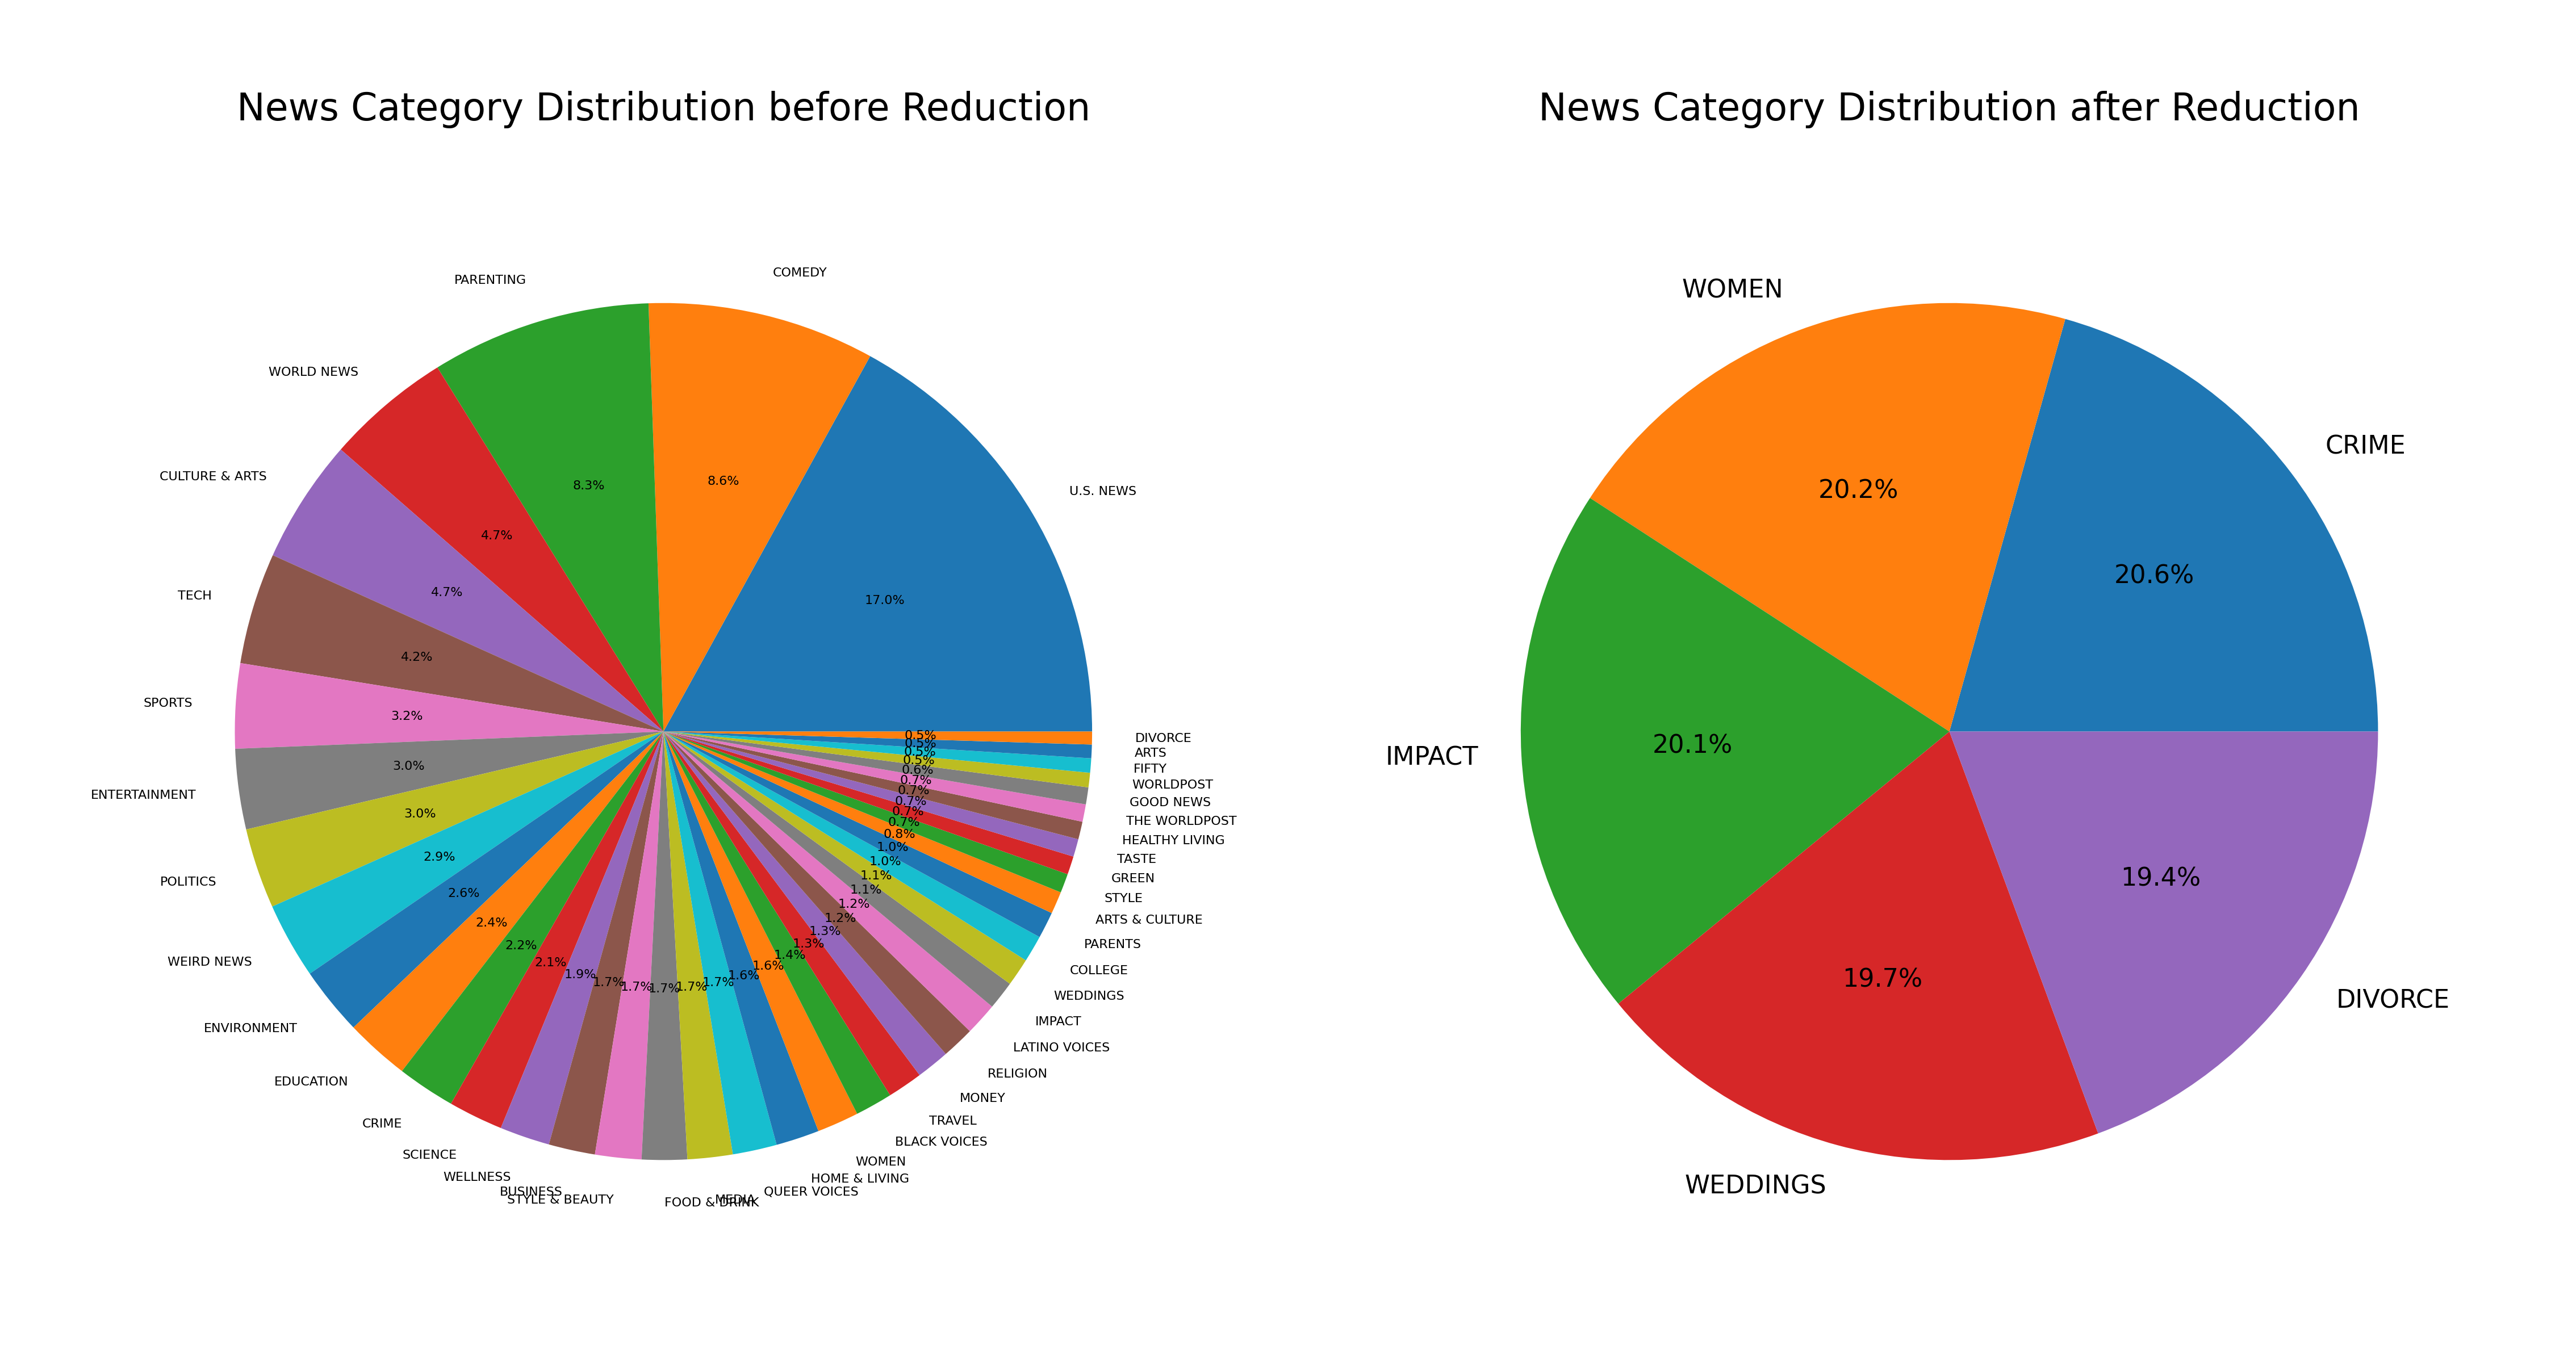

In [133]:
# Visualisation

fig = plt.figure(figsize=(7,5), dpi=1600)

ax1 = plt.subplot2grid((2,4),(0,0))
plt.pie(news['category'].value_counts(), labels=news['category'].unique(), autopct='%.1f%%', textprops={'fontsize': 1})
plt.title('News Category Distribution before Reduction', fontsize=3)

ax1 = plt.subplot2grid((2, 4), (0, 1))
plt.pie(less_news['category'].value_counts(), labels=less_news['category'].unique(), autopct='%.1f%%', textprops={'fontsize': 2})
plt.title('News Category Distribution after Reduction', fontsize=3);

In [134]:
print(f"Total number of items in orginal dataset: {sum(news['category'].value_counts())}")
print(f"Total number of items in reduced dataset:  {sum(less_news['category'].value_counts())}")

Total number of items in orginal dataset: 209527
Total number of items in reduced dataset:  17697


Now that the dataset has been drastically reduced in size, I will prepare the data for input into the machine learning models. I have chosen the 'short_description' column of the dataset to serve as the input features.

The first step in the NLP pre-processing pipeline is text normalisation. Text normalisation seeks to reduce variance in the vocabulary through removing unwanted characters such as punctuation and emojis or symbols, as well as case folding all words. For this data I have removed all non-alphabetical characters that are neither a digit or a space.

In [135]:
# Text normalisation

inputs = ['short_description']
for input in inputs:
  less_news[input] = less_news[input].str.lower().str.replace(r'[^a-zA-Z\d\s]', '', regex=True)

<ipython-input-135-36e31292000b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_news[input] = less_news[input].str.lower().str.replace(r'[^a-zA-Z\d\s]', '', regex=True)


A further way of normalising text data is through lemmatization. Lemmatization groups words together by reducing their to their etymological base form as found in the dictionary, allowing words that are derived from the same root to be considered the same word. For example, 'seeing' and 'saw'. I have lemmatised the descriptions using the WordNetLemmatizer object from NLTK.

In [137]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
less_news['stems'] = less_news['short_description'].map(lambda x: lemmatizer.lemmatize(x))

<ipython-input-137-84940e641203>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_news['stems'] = less_news['short_description'].map(lambda x: lemmatizer.lemmatize(x))


## Methodology


In this section I build five models for comparison. Multinomial Naive Bayes acts as the benchmark traditional model and is compared to 4 neural networks, 1 CNN model and 3 RNN-LSTM models. Within the 3 RNN-LSTM, I compare the use of pre-trained word embeddings, None, Word2Vec and GloVe, on the models classification accuracy. Due to computational restrictions, all neural network models use only 5 epochs, limiting their learning capacity.

#### Functions

In [64]:
# Plot learning history

def plot_history(hist):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [65]:
# Make predictions on test data
def predict(model):
  predictions = model.predict(X_test, batch_size=128)

  print(classification_report(y_test.argmax(axis=1),
                              predictions.argmax(axis=1),
                              target_names=[str(x) for x in lb.classes_]))

### Traditional model

For our baseline model I will use Multinomial Naive Bayes, a traditional machine learning model, with TF-IDF Vectorization.

Natural language processing involves vectorizing text data so that it can be represented in a numerical form that can be interpreted by computers. TF-IDF Vectorizer is a text vectorization method that represents each word in the description as its TF-IDF score. These feature vectors are then fed into the machine learning model, Multinomial Naive Bayes. Multinomial Naive Bayes is a simple and easy to understand algorithm for multi-class classification tasks and works well with bag-of-words vectorization methods such as TF-IDF.

In [75]:
# Split data into train and test split
X_train, X_test, y_train, y_test = train_test_split(less_news.stems, less_news.category, train_size = 0.75, random_state = 123456789)

# Feature vectorization
vectorizer = TfidfVectorizer(stop_words='english').fit(X_train)

train_bag = vectorizer.transform(X_train)
test_bag = vectorizer.transform(X_test)

In [76]:
# Training the classifier

classifier = MultinomialNB()

classifier.fit(X=train_bag, y=y_train)

train_accuracy = classifier.score(train_bag, y_train)
test_accuracy = classifier.score(test_bag, y_test)

In [77]:
train_accuracy, test_accuracy

(0.8306962025316456, 0.6696045197740113)

Without any hyper-parameter tuning or feature reduction (other than removing stopwords) the model provides an accuracy of 83% on the training data and 67% on the test data.

### Neural Network

#### Text Vectorization

In the following section I will evaluate the use of neural networks for this task and compare the train and test accuracy of the model to the baseline model discussed in the previous section.

Unlike Multinomial Naive Bayes, my neural networks do not support categorical labels. Hence, it is necessary to encode the labels as vectors in a process called one-hot encoding. We can do this using the LabelBinarizer object, which transforms each category into a vector such that the class `DIVORCE` may become represented as `[0, 0, 0, 1, 0]`.

In [138]:
# One hot encodings of class labels

lb = LabelBinarizer()
y = lb.fit_transform(less_news.category.values)

y.shape

(17697, 5)

Similarly to the traditional model we also need to vectorize the feature inputs. I have used Keras' Tokenizer object to create word embeddings for the lemmatized short descriptions. Word embeddings are able to capture more complex relationships between words than bag-of-words vectorization methods. Padding is used to ensure all vectors are the same length.

In [139]:
# Vectorization of input features

max_features = 1000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(less_news.stems.values)

X = tokenizer.texts_to_sequences(less_news.stems.values)

vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(X)

X.shape, vocab_size

((17697, 109), 25426)

Now that the data has been vectorized, I once again split it into train and test sets based on the same random state as before.

In [140]:
# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 123456789)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13272, 109), (13272, 5), (4425, 109), (4425, 5))

#### CNN

The first model I will build is a CNN model. A Convolutional Neural Network, or CNN, is a type of neural network that excels with visual data such as images or video. It involves convolutional layers, pooling layers and fully connected dense layers.

I build my CNN model using Keras. A model summary can be seem below. The Embedding layer of the CNN is where the word embedding is learnt during the training process. This is followed by 1 convolutional layer with max pooling, and two dense layers. Softmax activation is used for the final layer in order to predict the appropriate multi-class probabilities. The optimizer 'adam' is used as it is considered to be one of the faster optimisers.

In [81]:
# Removes any previously built models
clear_session()

In [141]:
input_len = X_train.shape[1]
embedding_dim = 128
num_class = len(set(less_news.category))

cnn = Sequential()
cnn.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=input_len))
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(num_class, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 109, 128)          128000    
                                                                 
 conv1d (Conv1D)             (None, 105, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 52, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6656)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1704192   
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                      

#### Bi-directional RNN with LSTM

The second model is a bi-directional RNN with LSTM. Unlike the CNN, this model replaces the convolutional and max pooling layer with a Bidirectional RNN layer with an LSTM component. It also has a third dense layer. Akin to the previous model the loss function is categorical cross entropy for multi-class classification.

The model is summarised below.

In [87]:
clear_session()

In [88]:
# Creates Bidirectional LSTM model

input_len = X_train.shape[1]
embedding_dim = 128
num_class = len(set(less_news.category))

rnn = Sequential()
rnn.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=input_len))
rnn.add(Bidirectional(LSTM(units=96, dropout=0.05, recurrent_dropout=0.2)))
rnn.add(Dense(512, activation="relu"))
rnn.add(Dense(256, activation="relu"))
rnn.add(Dense(num_class, activation='softmax'))

rnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 109, 128)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 192)              172800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               98816     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 532,229
Trainable params: 532,229
Non-trainable params: 0
__________________________________________________

#### With Pre-trained Word Embeddings

It is also possible to use pre-trained word embeddings rather than training your own word embeddings when fitting the neural network to the data. Two such pre-trained word embedding algorithms are Word2Vec and GloVe. Using pre-trained word embeddings can help reduce the time and space complexity of your model.

##### Word2Vec

Word2Vec, developed by Google, is commonly used to create word embeddings. Word2Vec employs a two layer neural network to achieve its word embeddings. n the following section I used to Word2Vec on my model and add the weights to my RNN-LSTM model.

In [93]:
# Initialise word2vec weights
word2vec = models.Word2Vec(news.stems.str.split(), max_vocab_size=5000, window=5, workers=8, min_count=1)
keyed_vectors = word2vec.wv
weights = keyed_vectors.vectors

In [94]:
# Add word2vec weights to embedding layer of RNN-LSTM network
clear_session()

input_len = X_train.shape[1]
num_class = len(set(less_news.category))

w2v = Sequential()
w2v.add(Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights], trainable=False))
w2v.add(Bidirectional(LSTM(units=96, dropout=0.05, recurrent_dropout=0.2)))
w2v.add(Dense(512, activation="relu"))
w2v.add(Dense(256, activation="relu"))
w2v.add(Dense(num_class, activation='softmax'))

w2v.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         229900    
                                                                 
 bidirectional (Bidirectiona  (None, 192)              151296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               98816     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 612,625
Trainable params: 382,725
Non-trainable params: 229,900
____________________________________________

##### GloVe

GloVe has the same aim as Word2Vec but creates its embeddings via a co-occurance matrix factorization. GloVe, Global Vectors for Word Representation, was developed by the Stanford NLP Group. GloVe is considered to be a faster and more simpler algorithm to Word2Vec's neural approach. In this section, I similarly use GloVe to create embedding vectors for my RNN-LSTM model. I have implemented GloVe using Torch.

In [99]:
# Creating list of vocab from X_train
vocab = list(tokenizer.word_index.keys())

In [100]:
# Loading glove embeddings
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [101]:
clear_session()

input_len = X_train.shape[1]
embedding_dim = 100
num_class = len(set(less_news.category))

# apply glove embeddings to my vocabulary
embedding_vectors = glove_embedding[vocab]

glove = Sequential()
glove.add(Embedding(input_dim=len(vocab), output_dim=embedding_dim, weights=[embedding_vectors], input_length=input_len, trainable=False))
glove.add(Bidirectional(LSTM(units=96, dropout=0.05, recurrent_dropout=0.2)))
glove.add(Dense(512, activation="relu"))
glove.add(Dense(256, activation="relu"))
glove.add(Dense(num_class, activation='softmax'))

glove.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 109, 100)          2542500   
                                                                 
 bidirectional (Bidirectiona  (None, 192)              151296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               98816     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,925,225
Trainable params: 382,725
Non-trainable params: 2,542,500
________________________________________

## Results

In this section, I discuss the performance of each neural model and compare them to the baseline train and test accuracy of 83 and 67% respectively. Each model is fitted with Early Stopping in which patience is set to 2 in order to minimise training time.

#### CNN Results

The CNN model stopped after 4 epochs, after reaching its peak performance at epoch 2 with 63.1% test accuracy.

In [83]:
# Fits model to training data and trains model

hist2 = cnn.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=5,
                  verbose=2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/5
415/415 - 61s - loss: 1.1386 - accuracy: 0.5140 - val_loss: 0.9365 - val_accuracy: 0.6149 - 61s/epoch - 147ms/step
Epoch 2/5
415/415 - 39s - loss: 0.8250 - accuracy: 0.6690 - val_loss: 0.8993 - val_accuracy: 0.6310 - 39s/epoch - 93ms/step
Epoch 3/5
415/415 - 39s - loss: 0.6749 - accuracy: 0.7335 - val_loss: 0.9682 - val_accuracy: 0.6264 - 39s/epoch - 94ms/step
Epoch 4/5
415/415 - 43s - loss: 0.4847 - accuracy: 0.8125 - val_loss: 1.1727 - val_accuracy: 0.6140 - 43s/epoch - 105ms/step


The learning history of the model is plotted below and we can see that whilst training accuracy continues to improve, test accuracy is slowly decreasing.

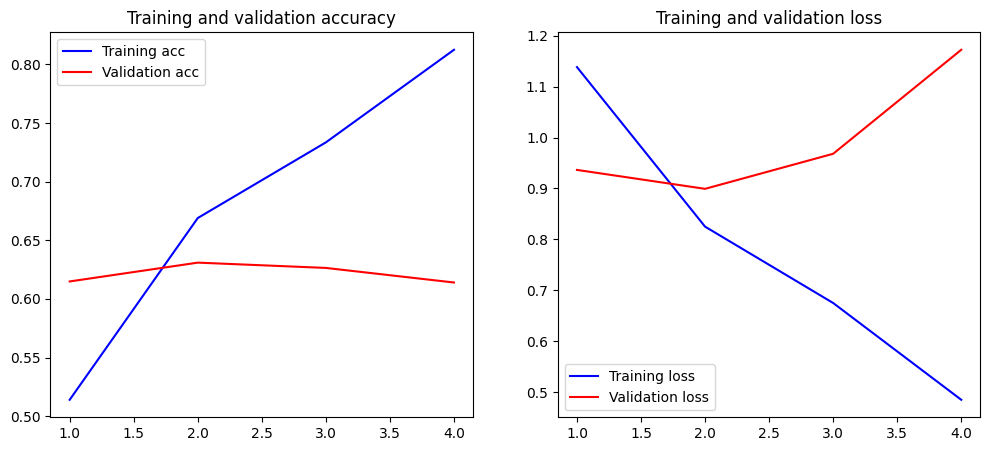

In [84]:
# Plot history
plot_history(hist2)

The CNN model most accurately predicted WEDDING class news but struggled to predict WOMEN class news.

In [85]:
predict(cnn)

35/35 [==============================] - 3s 71ms/step
              precision    recall  f1-score   support

       CRIME       0.61      0.77      0.68       899
     DIVORCE       0.63      0.64      0.64       823
      IMPACT       0.56      0.57      0.56       905
    WEDDINGS       0.78      0.64      0.71       943
       WOMEN       0.49      0.43      0.46       855

    accuracy                           0.61      4425
   macro avg       0.62      0.61      0.61      4425
weighted avg       0.62      0.61      0.61      4425



The loss and accuracy on the test set are printed below. At 61.4% test accuracy this model falls slightly short of the baseline model.

In [86]:
t_loss1, train_acc1 = cnn.evaluate(X_train, y_train, verbose=0)
loss1, test_acc1 = cnn.evaluate(X_test, y_test, verbose=0)

loss1, test_acc1

(1.172672152519226, 0.614011287689209)

#### RNN-LSTM Results

The RNN-LSTM model also stopped learning after 4 epochs, peaking at epoch 3 with 64.61% accuracy - still shy of the baseline model.

In [89]:
# Fits model to training data and trains model

hist = rnn.fit(X_train, y_train,
                 validation_data=(X_test, y_test),
                 epochs=5,
                 verbose=2,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/5
415/415 - 297s - loss: 1.1810 - accuracy: 0.4726 - val_loss: 0.9826 - val_accuracy: 0.5851 - 297s/epoch - 716ms/step
Epoch 2/5
415/415 - 274s - loss: 0.8748 - accuracy: 0.6439 - val_loss: 0.8691 - val_accuracy: 0.6450 - 274s/epoch - 659ms/step
Epoch 3/5
415/415 - 263s - loss: 0.7829 - accuracy: 0.6892 - val_loss: 0.8953 - val_accuracy: 0.6461 - 263s/epoch - 633ms/step
Epoch 4/5
415/415 - 274s - loss: 0.7299 - accuracy: 0.7133 - val_loss: 0.8983 - val_accuracy: 0.6425 - 274s/epoch - 661ms/step


The history is plotted below. We can see that the test accuracy suddenly hits a plateau at the second epoch.

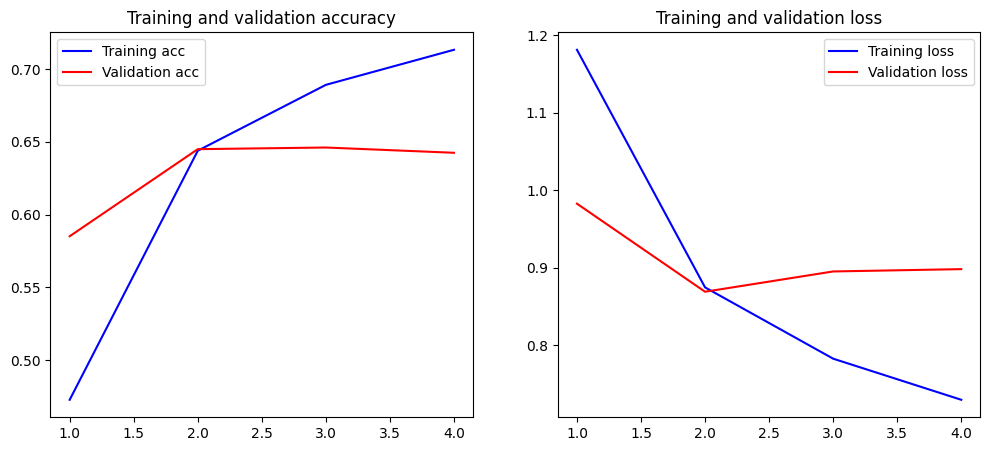

In [90]:
plot_history(hist)

The classification report is also printed below. Similarly to the CNN model, WEDDING news was the easiest to classify whereas WOMEN was the most difficult.

In [91]:
predict(rnn)

35/35 [==============================] - 9s 244ms/step
              precision    recall  f1-score   support

       CRIME       0.62      0.80      0.70       899
     DIVORCE       0.63      0.68      0.65       823
      IMPACT       0.64      0.55      0.59       905
    WEDDINGS       0.74      0.76      0.75       943
       WOMEN       0.56      0.41      0.47       855

    accuracy                           0.64      4425
   macro avg       0.64      0.64      0.63      4425
weighted avg       0.64      0.64      0.64      4425



The test accuracy was 64.24% overall, demonstrating the effectiveness of the bi-directional RNN-LSTM model over the CNN model but still falling short of the baseline accuracy of 67%.

In [92]:
# Evaluate model

t_loss2, train_acc2 = rnn.evaluate(X_train, y_train, verbose=0)
loss2, test_acc2 = rnn.evaluate(X_test, y_test, verbose=0)
loss2, test_acc2

(0.8982595801353455, 0.6424858570098877)

#### Word2Vec Results

The impact of Word2Vec had a decisively negative impact on train and test accuracy. Again, the history shows a plateau around the second epoch. However, due to the few numbers of epochs it is hard to make generalisations about training with such little information.

In [95]:
# Train word2vec model
hist3 = w2v.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=5,
                verbose=2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)]);

Epoch 1/5
415/415 - 230s - loss: 1.2974 - accuracy: 0.4338 - val_loss: 1.1522 - val_accuracy: 0.5064 - 230s/epoch - 554ms/step
Epoch 2/5
415/415 - 223s - loss: 1.0798 - accuracy: 0.5497 - val_loss: 1.0619 - val_accuracy: 0.5548 - 223s/epoch - 538ms/step
Epoch 3/5
415/415 - 222s - loss: 0.9812 - accuracy: 0.6004 - val_loss: 1.0573 - val_accuracy: 0.5627 - 222s/epoch - 534ms/step
Epoch 4/5
415/415 - 221s - loss: 0.8928 - accuracy: 0.6337 - val_loss: 1.0384 - val_accuracy: 0.5785 - 221s/epoch - 532ms/step
Epoch 5/5
415/415 - 221s - loss: 0.8192 - accuracy: 0.6635 - val_loss: 1.0538 - val_accuracy: 0.5772 - 221s/epoch - 533ms/step


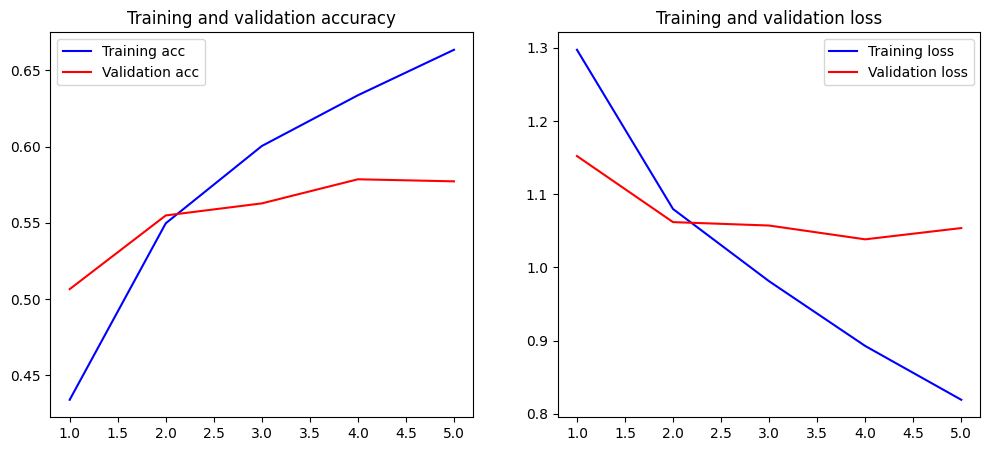

In [96]:
plot_history(hist3)

Unlike the previous two models, using Word2Vec increased precision in certain categories. This model found DIVORCE related articles the easiest to categorise and IMPACT articles the most difficult.

In [97]:
predict(w2v)

35/35 [==============================] - 9s 234ms/step
              precision    recall  f1-score   support

       CRIME       0.61      0.72      0.66       899
     DIVORCE       0.67      0.48      0.56       823
      IMPACT       0.48      0.54      0.51       905
    WEDDINGS       0.62      0.73      0.67       943
       WOMEN       0.52      0.39      0.44       855

    accuracy                           0.58      4425
   macro avg       0.58      0.57      0.57      4425
weighted avg       0.58      0.58      0.57      4425



Overall the accuracy was significantly lower using the pre-trained Word2Vec word embeddings with a test accuracy of 57.7%, the lowest test accuracy so far.

In [98]:
# Evaluate model

t_loss3, train_acc3 = w2v.evaluate(X_train, y_train, verbose=0)
loss3, test_acc3 = w2v.evaluate(X_test, y_test, verbose=0)
loss3, test_acc3

(1.0538086891174316, 0.5771751403808594)

#### GloVe Results

The GloVe word embeddings were likewise unsuccessful, starting at a test accuracy as low as 45% and peaking at 57% on the fifth epoch.

In [102]:
# Train GloVe model
hist4 = glove.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=5,
                  verbose=2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]);

Epoch 1/5
415/415 - 245s - loss: 1.4158 - accuracy: 0.3576 - val_loss: 1.2856 - val_accuracy: 0.4538 - 245s/epoch - 591ms/step
Epoch 2/5
415/415 - 224s - loss: 1.2312 - accuracy: 0.4739 - val_loss: 1.1713 - val_accuracy: 0.5003 - 224s/epoch - 541ms/step
Epoch 3/5
415/415 - 223s - loss: 1.1422 - accuracy: 0.5194 - val_loss: 1.1395 - val_accuracy: 0.5236 - 223s/epoch - 538ms/step
Epoch 4/5
415/415 - 221s - loss: 1.0762 - accuracy: 0.5485 - val_loss: 1.0645 - val_accuracy: 0.5340 - 221s/epoch - 533ms/step
Epoch 5/5
415/415 - 223s - loss: 1.0124 - accuracy: 0.5779 - val_loss: 1.0272 - val_accuracy: 0.5706 - 223s/epoch - 536ms/step


However, the learning history appears promising with both the train and test accuracy sharply increasing with each epoch. This suggests that the model accuracy would continue to increase with further epochs.

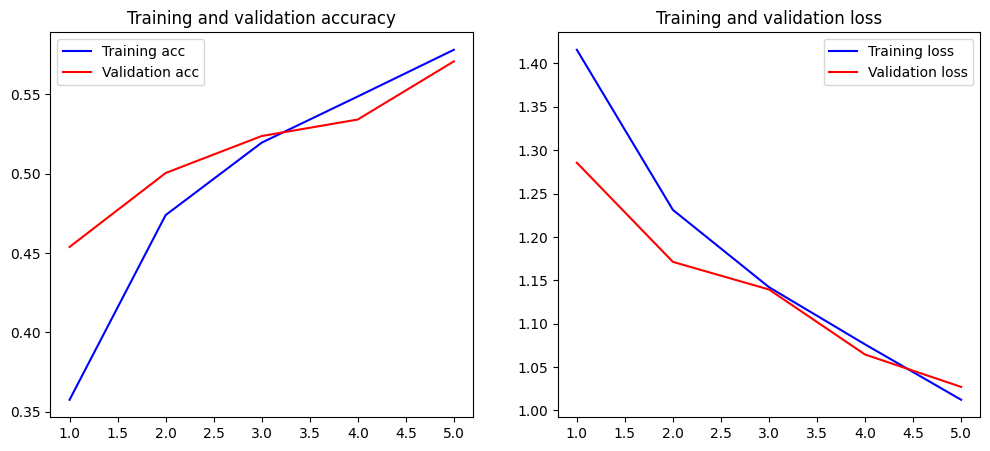

In [103]:
plot_history(hist4)

The GloVe word embeddings seem equally successful for each category, whilst WEDDINGS remains the easiest category to classify.

In [104]:
predict(glove)

35/35 [==============================] - 9s 241ms/step
              precision    recall  f1-score   support

       CRIME       0.56      0.78      0.65       899
     DIVORCE       0.53      0.60      0.57       823
      IMPACT       0.56      0.46      0.50       905
    WEDDINGS       0.65      0.65      0.65       943
       WOMEN       0.54      0.35      0.42       855

    accuracy                           0.57      4425
   macro avg       0.57      0.57      0.56      4425
weighted avg       0.57      0.57      0.56      4425



In sum, the model produces the lowest test accuracy of all models - 57%. However, considering the incline in the test accuracy shown in the learning history, further evaluation involving an increased number of epochs is warranted.


In [105]:
# Evaluate model

t_loss4, train_acc4 = glove.evaluate(X_train, y_train, verbose=0)
loss4, test_acc4 = glove.evaluate(X_test, y_test, verbose=0)
loss4, test_acc4

(1.0272153615951538, 0.5706214904785156)

## Conclusion

In conclusion, none of the neural networks reach the baseline test accuracy of 67% as can be seen in the bar plot below. Whilst, CNN model surpasses the baseline in train accuracy it falls short regarding test accuracy and appears to generalise the least well out of all the models. The highest performing neural network is the RNN-LSTM model, hitting a nice balance between train and test accuracies at 64% classification accuracy on the test set. Whilst pre-trained word embeddings showed a decrease in model performance, the RNN-LSTM using GloVe warrants further investigation.   

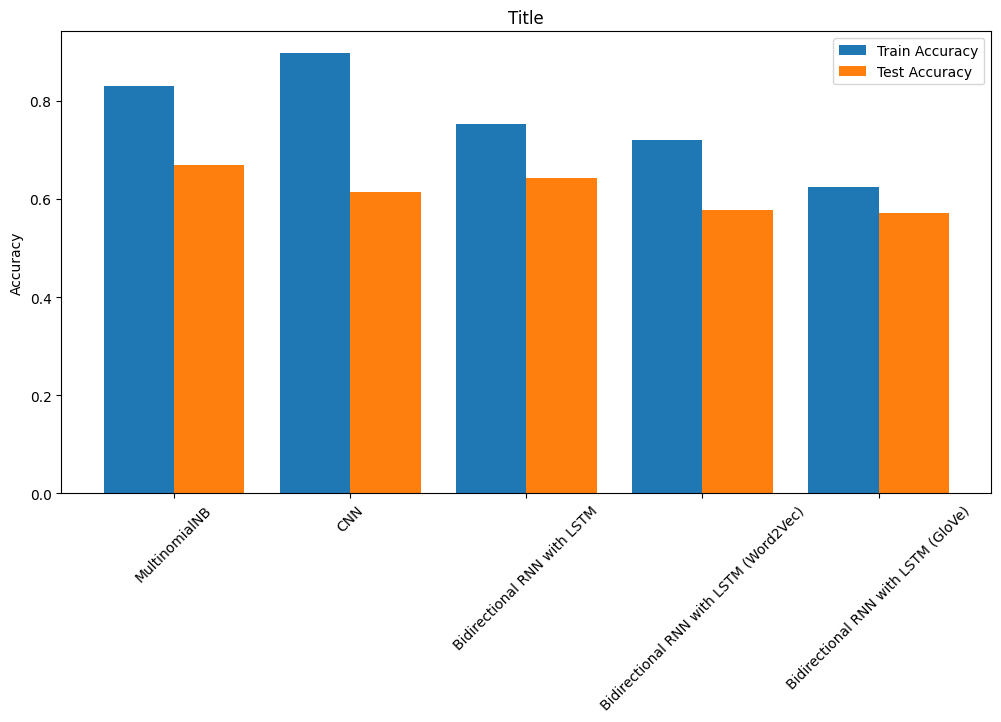

In [106]:
# Plot bar chart for train, test accuracies per model
train_accuracies = [train_accuracy, train_acc1, train_acc2, train_acc3, train_acc4]
test_accuracies = [test_accuracy, test_acc1, test_acc2, test_acc3, test_acc4]

X_axis = np.arange(5)
plt.figure(figsize=(12,6))
plt.bar(X_axis - 0.2, train_accuracies, width=0.4, label='Train Accuracy')
plt.bar(X_axis + 0.2, test_accuracies, width=0.4, label='Test Accuracy')
plt.xticks(X_axis,
           ['MultinomialNB','CNN','Bidirectional RNN with LSTM', 'Bidirectional RNN with LSTM (Word2Vec)', 'Bidirectional RNN with LSTM (GloVe)'],
           rotation=45)
plt.ylabel('Accuracy')
plt.title("Train and test accuracies of different models")
plt.legend()
plt.show()

During the writing of this report I encountered many issues when training the neural networks due to lack of computational power, resulting in long training times. Whilst I performed various steps in order to mitigate these issues such as reducing the size of the dataset, creating word embeddings and limiting the number of epochs, these long training times meant that I was not able to investigate each model further.

Hence, future work should involve investigating the impact of the number of training epochs, different optimizers such as Stochastic Gradient Descent, and an evaluation of the effect of different numbers of layers and nodes on each layer. Further layers could have also been added to the model such as aa SpatialDropout layer to prevent overfitting.

Due to the promising nature of the learning history, future work ought to include an investigation of the RNN-LSTM model using GloVe to see if an increased number of epochs (even just 10 epochs instead of 5) produces a higher test accuracy or introduces a plateau.

Overall, however, despite the constraints opposed upon the neural networks, they only slighly underperformed the traditional model. Multinomail Naive Bayes is ideal for small datasets and is commonly used in NLP, whilst neural networks outperform such algorithms with larger corpora of data. Given the utilisation of the complete dataset was enabled, I expect the test accuracy of the neural network to certaintly surpass that of the baseline.